# CUADS Data Quality Notebook

## About CUADS
CUADS is a multimodal dataset contained ECG, PPG and GSR physiological signals recorded while participants viewed pre-tagged affective movie clips. After each movie clip, participants completed a SAM survey to evaluate arousal and valence.

The dataset can obtained from IEEE DataPort here: [https://ieee-dataport.org/documents/clarkson-university-affective-dataset-cuads](https://ieee-dataport.org/documents/clarkson-university-affective-dataset-cuads)


## About this notebook
This notebook is used to perform quality assessment of the data contained in CUADS. We evaluate and score each of the three physiological signals, and the SAM survey response data.

## Instructions
Download and extract the CUADS dataset. In the first cell, update the value `dataset_root` to path to the `cuads` folder in the extracted dataset. This notebook produces several output images. The path to save the output can be set in the `dataset_output` variable, and defaults to `./output`.

For help, please reach out to the authors.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
from ardt.datasets import MultiDataset
from ardt.datasets.cuads import CuadsDataset
from ardt.datasets.cuads.CuadsDataset import CUADS_NUM_PARTICIPANTS, CUADS_NUM_MEDIA_FILES
from ardt.datasets.ascertain import AscertainDataset
from ardt.datasets.ascertain.AscertainDataset import ASCERTAIN_NUM_PARTICIPANTS, ASCERTAIN_NUM_MEDIA_FILES
from ardt.datasets.dreamer import DreamerDataset
from ardt.datasets.dreamer.DreamerDataset import DREAMER_NUM_PARTICIPANTS, DREAMER_NUM_MEDIA_FILES

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters

# Path to the extracted dataset
dataset_root='./dataset/cuads'

# Path to write output images and numpy files
dataset_output=f'./output'

if not os.path.exists(dataset_root):
    print("ERROR: No dataset found at {dataset_root}")

if not os.path.exists(dataset_output):
    os.mkdir(dataset_output)

E0000 00:00:1738084560.551686   30446 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738084560.553984   30446 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup Dataset for Processing

Here we use ARDT to load the CUADS, ASCERTAIN and DREAMER datasets, combinbing them together into one large MultiDataset for analysis.

ECG Quality and Participant Response Scoring both use `dataset` which is set on the last line ... you can set `dataset=cuads` to only score cuads, `dataset=ascertain` to only score ascertain, etc. The default is to use the `multiset` which wraps CUADS, ASCERTAIN, and DREAMER into one large virtual dataset with 119 participants, 74 media files, and 3,216 trials.

In [2]:
Fs=256                      # Physiological signal sampling rate. DO NOT MODIFY.
CUADS_NUM_PARTICIPANTS=44   # CUADS enrolled 44 participants.
CUADS_NUM_MOVIECLIPS=20     # Participants were each shown 20 movie clips

datasets = []
media_offset = 0
participant_offset = 0

print("Loading CUADS...")
cuads = CuadsDataset(mediafile_offset=participant_offset,participant_offset=media_offset)
datasets.append(cuads)
media_offset += CUADS_NUM_MEDIA_FILES
participant_offset += CUADS_NUM_PARTICIPANTS

print("Loading ASCERTAIN...")
ascertain = AscertainDataset(mediafile_offset=participant_offset,participant_offset=media_offset)
datasets.append(ascertain)
media_offset += ASCERTAIN_NUM_MEDIA_FILES
participant_offset += ASCERTAIN_NUM_PARTICIPANTS

print("Loading DREAMER...")
dreamer = DreamerDataset(mediafile_offset=participant_offset,participant_offset=media_offset)
datasets.append(dreamer)
media_offset += DREAMER_NUM_MEDIA_FILES
participant_offset += DREAMER_NUM_PARTICIPANTS

# Note -- calling preload and load_trials on the multiset calls it on each
#         individual dataset too ... so you can still use dreamer, ascertain
#         and cuads independently too...
multiset = MultiDataset(datasets)   # 121 participants, 74 videos ...
multiset.preload()
multiset.load_trials()


print()
print(f"ASCERTAIN has {len(ascertain.participant_ids)} participants")
print(f"ASCERTAIN has {len(ascertain.media_ids)} media files")
print(f"ASCERTAIN has {len(ascertain.trials)} trials")
print()
print(f"CUADS has {len(cuads.participant_ids)} participants")
print(f"CUADS has {len(cuads.media_ids)} media files")
print(f"CUADS has {len(cuads.trials)} trials")
print()
print(f"DREAMER has {len(dreamer.participant_ids)} participants")
print(f"DREAMER has {len(dreamer.media_ids)} media files")
print(f"DREAMER has {len(dreamer.trials)} trials")
print()
print(f"MultiDataset has {len(multiset.participant_ids)} participants")
print(f"MultiDataset has {len(multiset.media_ids)} media files")
print(f"MultiDataset has {len(multiset.trials)} trials")

# `dataset` is used throughout this notebook ... pick any dataset individually, or
# use the multiset...
dataset = multiset


Loading CUADS...
Loading ASCERTAIN...
Loading DREAMER...

ASCERTAIN has 58 participants
ASCERTAIN has 36 media files
ASCERTAIN has 2088 trials

CUADS has 38 participants
CUADS has 20 media files
CUADS has 714 trials

DREAMER has 23 participants
DREAMER has 18 media files
DREAMER has 414 trials

MultiDataset has 119 participants
MultiDataset has 74 media files
MultiDataset has 3216 trials


# ECG Scoring

The following cell scores the ECGs using NeuroKit2. NeuroKit2 ontains several methods for cleaning an ECG, listed in the `methods` list. The Zhoe2018 method scores the cleaned ECG, rating them as `unacceptable`, `barely acceptable` or `excellent`

For each ecg signal in the dataset, we attempt to find the NeuroKit2 method that results in the highest quality score.

__NOTE:__ in the Data Descriptor submitted to IEEE-Data, we only report quality results using the `neurokit` Method. This method applies a 0.5 Hz high-pass butterworth filter (order = 5), followed by powerline filtering (nk defaults to 50 Hz, we specify 60Hz in the call to override). Below, we search all available methods and achieve "Excellent" scoring for all 714 samples in the dataset


In [3]:
# Map column numbers to ECG Channel Names - only used for logging
# column_to_channel_name = {15: "LA-RA", 16: "LL-LA", 17: "LL-RA"}
 # Map Zhao2018 result labels to integer values
quality_map = { "Unacceptable": 0, "Unnacceptable": 0, "Barely acceptable": 1, "Excellent": 2 }

# List of methods for ECG Cleaning in NeuroKit2
methods = ["neurokit", "biosppy", "pantompkins1985", "hamilton2002", "elgendi2010", "engzeemod2012", "vg"]

# Used to track how many times each method resulted in the best score for each signal
bestmethod_counts = {"neurokit": 0, "biosppy": 0, "pantompkins1985": 0, "hamilton2002": 0, "elgendi2010": 0, "engzeemod2012": 0, "vg": 0}

# Used to track how many ecg signals received each score
quality_results = { 0: 0, 1: 0, 2: 0 }

# Used to track the best scores by ecg-channel
quality_by_channel = {0: { 0: 0, 1: 0, 2: 0 }, 1: { 0: 0, 1: 0, 2: 0 }, 2: { 0: 0, 1: 0, 2: 0 } }

for trial in dataset.trials:
    signal = trial.load_signal_data('ECG')

    for channel in range(trial.get_signal_metadata('ECG')['n_channels']):
        quality = "x"
        channel_dat=signal[channel+1,:]

        methodidx = 0
        best_quality = -1
        best_quality_method = ""

        # Loop until we get an "Excellent" result, or run out of methods to test...
        while quality != "Excellent" and methodidx < len(methods):
            current_method = methods[methodidx]

            # Clean the ECG signal using the current method
            ecg_cleaned = nk.ecg_clean(channel_dat, sampling_rate=Fs, powerline=60, method=current_method)

            # Evaluate the ECG signal using fuzzy comprehensive SQI evaluation
            quality = nk.ecg_quality(ecg_cleaned, sampling_rate=Fs, method='zhao2018', approach="fuzzy")

            # Is this better than the best one we've found so far?
            if quality_map[quality] > best_quality:
                best_quality = quality_map[quality]
                best_quality_method = current_method

            methodidx += 1

        quality_by_channel[channel][best_quality] += 1
        bestmethod_counts[best_quality_method] += 1
        quality_results[best_quality] += 1

print("\nECG Signal Counts by Best Quality (0=Unacceptable, 1=Barely acceptable, 2=Excellent)")
print(quality_results)

print("\nECG Signal Counts by Best Method")
print(bestmethod_counts)

print("\nECG Signal Counts by By ECG-Channel (0=LA-RA, 1=LL-LA, 2=LL-RA)")
print(quality_by_channel)

/home/timcsf/miniconda3/envs/aer2025b/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/timcsf/miniconda3/envs/aer2025b/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/timcsf/miniconda3/envs/aer2025b/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/timcsf/miniconda3/envs/aer2025b/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/timcsf/miniconda3/envs/aer2025b/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/timcsf/miniconda3/envs/aer2025b/lib/python3.12


ECG Signal Counts by Best Quality (0=Unacceptable, 1=Barely acceptable, 2=Excellent)
{0: 0, 1: 495, 2: 6651}

ECG Signal Counts by Best Method
{'neurokit': 5932, 'biosppy': 621, 'pantompkins1985': 220, 'hamilton2002': 271, 'elgendi2010': 88, 'engzeemod2012': 7, 'vg': 7}

ECG Signal Counts by By ECG-Channel (0=LA-RA, 1=LL-LA, 2=LL-RA)
{0: {0: 0, 1: 259, 2: 2957}, 1: {0: 0, 1: 236, 2: 2980}, 2: {0: 0, 1: 0, 2: 714}}


# PPG Scoring

We score PPG by looking at the heartrate inferred from PPG, and computing the euclidean distance to the average heartrate computed across the 3 ECG channels. We then score them on their distance from ECG_HR based on the mean and stdev of the distances.

If d < mean - stdev (between 0 and 1 stdev less tham mean), it is excellent
if (mean-stdev) <= d <= (mean+stdev), it is good
if d > (mean~stdev), it is poor

```
Let m be the mean distance
Let s be the stdev of the distances

  |----- EXCELLENT ----|--- GOOD ----|----- POOR -------|
  |--------------------|------+------|------------------|
min(d)               (m-s)    m    (m+s)              max(d)

In [4]:
hr_distances = []

# NOTE: Only CUADS has PPG Data available so we score that directly instead of using the multiset

for trial in cuads.trials:
    print(f"Participant {trial.participant_id} Video {trial.media_id}")
    ecg_hr_signal = trial.load_signal_data('ECGHR')[1:3,:].transpose()
    ppg_hr_signal = trial.load_signal_data('PPGHR')[1,:].transpose()

    ecg_avg_hr = np.array(ecg_hr_signal,dtype=float).mean(axis=1)
    ppg_hr = np.array(ppg_hr_signal,dtype=float)
    hr_distances.append(np.sqrt(np.sum(np.square(ecg_avg_hr-ppg_hr))))

print("Heart Rate Stats:")
hr_distances = np.array(hr_distances)
mu = np.mean(hr_distances)
sigma = np.std(hr_distances)
print(f"Min: {np.min(hr_distances)})")
print(f"Max: {np.max(hr_distances)}")
print(f"Stdev: {sigma}")
print(f"Mean: {mu}")
print("\nScores:")
print(f"Poor: {len([ d for d in hr_distances if d > (mu+sigma)])}")
print(f"Good: {len([ d for d in hr_distances if (mu-sigma) <= d <= (mu+sigma)])}")
print(f"Excellent: {len([ d for d in hr_distances if d < (mu-sigma)])}")



Participant 1 Video 1
Participant 1 Video 2
Participant 1 Video 3
Participant 1 Video 4
Participant 1 Video 5
Participant 1 Video 6
Participant 1 Video 7
Participant 1 Video 8
Participant 1 Video 9
Participant 1 Video 10
Participant 1 Video 11
Participant 1 Video 12
Participant 1 Video 13
Participant 1 Video 14
Participant 1 Video 15
Participant 1 Video 16
Participant 1 Video 17
Participant 1 Video 18
Participant 1 Video 19
Participant 2 Video 20
Participant 2 Video 4
Participant 2 Video 6
Participant 2 Video 18
Participant 2 Video 10
Participant 2 Video 17
Participant 2 Video 7
Participant 2 Video 11
Participant 2 Video 1
Participant 2 Video 19
Participant 2 Video 15
Participant 2 Video 9
Participant 2 Video 2
Participant 2 Video 13
Participant 2 Video 16
Participant 2 Video 12
Participant 2 Video 5
Participant 2 Video 14
Participant 2 Video 8
Participant 3 Video 5
Participant 3 Video 6
Participant 3 Video 20
Participant 3 Video 7
Participant 3 Video 10
Participant 3 Video 15
Particip

# GSR Scoring

Implemented across the next two cells

We score GSR based on RMSE of the Skin Conductance signals. We calculate a reference signal for each participant by averaging skin conductance for all samples from that participant. We then compute the distance from baseline for each signal and rate them as `poor`, `good` or `excellent` based on distance from the mean.

In [5]:
gsr_signals_by_participant = {}

# Note - we only score GSR data from CUADS right now...

for trial in cuads.trials:
    if not trial.participant_id in gsr_signals_by_participant:
        gsr_signals_by_participant[trial.participant_id] = []
    print(f"Participant {trial.participant_id} Video {trial.media_id}")
    skin_conductance = trial.load_signal_data('GSR')[1,:].transpose()
    gsr_signals_by_participant[trial.participant_id].append(skin_conductance)

Participant 1 Video 1
Participant 1 Video 2
Participant 1 Video 3
Participant 1 Video 4
Participant 1 Video 5
Participant 1 Video 6
Participant 1 Video 7
Participant 1 Video 8
Participant 1 Video 9
Participant 1 Video 10
Participant 1 Video 11
Participant 1 Video 12
Participant 1 Video 13
Participant 1 Video 14
Participant 1 Video 15
Participant 1 Video 16
Participant 1 Video 17
Participant 1 Video 18
Participant 1 Video 19
Participant 2 Video 20
Participant 2 Video 4
Participant 2 Video 6
Participant 2 Video 18
Participant 2 Video 10
Participant 2 Video 17
Participant 2 Video 7
Participant 2 Video 11
Participant 2 Video 1
Participant 2 Video 19
Participant 2 Video 15
Participant 2 Video 9
Participant 2 Video 2
Participant 2 Video 13
Participant 2 Video 16
Participant 2 Video 12
Participant 2 Video 5
Participant 2 Video 14
Participant 2 Video 8
Participant 3 Video 5
Participant 3 Video 6
Participant 3 Video 20
Participant 3 Video 7
Participant 3 Video 10
Participant 3 Video 15
Particip

In [6]:
rmse_results = {}

for participant, gsr_signals in gsr_signals_by_participant.items():
    # Determine the maximum length of segmented data files for this participant
    max_length = max(len(gsr_signal) for gsr_signal in gsr_signals)

    # Pad all segmented data files to the maximum length with zeros
    padded_datasets = [np.pad(gsr_signal, (0, max_length - len(gsr_signal)), mode='constant') for gsr_signal in gsr_signals]

    # Compute the reference signal (mean across padded datasets)
    reference_signal = np.mean(padded_datasets, axis=0)

    # Compute normalized RMSE for each segmented data file
    rmses = []
    for gsr_signal in gsr_signals:
        T_i = len(gsr_signal)  # Actual length of the dataset
        padded_dataset = np.pad(gsr_signal, (0, max_length - T_i), mode='constant')  # Pad to match reference length
        rmse = np.sqrt(np.sum((padded_dataset[:T_i] - reference_signal[:T_i]) ** 2) / T_i)  # Normalize by T_i
        rmses.append(rmse)

    # Compute thresholds for classification
    mu = np.mean(rmses)  # Mean of RMSE values
    sigma = np.std(rmses)  # Standard deviation of RMSE values

    classifications = []
    for rmse in rmses:
        if rmse < mu - sigma:
            classifications.append("Excellent")
        elif mu - sigma <= rmse <= mu + sigma:
            classifications.append("Good")
        else:
            classifications.append("Poor")

    # Store results and classifications for the participant
    rmse_results[participant] = {
        "RMSE Values": rmses,
        "Classifications": classifications
    }

# Convert results into a DataFrame for easier analysis
participant_results = []
for participant, results in rmse_results.items():
    for i, (rmse, classification) in enumerate(zip(results["RMSE Values"], results["Classifications"])):
        participant_results.append({
            "Participant": participant,
            "Segmented File ID": i + 1,
            "RMSE": rmse,
            "Classification": classification
        })

# Create a DataFrame from the results
results_df = pd.DataFrame(participant_results)

# Display the results in tabular format
# Count the total number of each classification
classification_counts = results_df["Classification"].value_counts()

# Display the counts
print("Total Classifications:")
print(classification_counts)

Total Classifications:
Classification
Good         471
Poor         128
Excellent    115
Name: count, dtype: int64


# Participant Response Evaluation

We consider Randolph's Kappa to assess intra-rater agreement of all participants for each movie clip. We expect better than chance agreement and hope to fair-to-moderate agreement based on other studies.

We also consider how participants' classification of each movie clip matches the expected classification label (where movies are classified into Quadrants 1, 2, 3 or 4 on the Valence-Arousal space). Confusion matrices are generated to visualize this information.

In [7]:
# These are what we expect based on pretagged media from MANHOB-HCI
###################################################################
participant_responses_quadrant = np.zeros(shape=(len(dataset.participant_ids), len(dataset.media_ids)), dtype=int)
expected_responses_quadrant = np.zeros(shape=(len(dataset.media_ids)), dtype=int)

for trial in dataset.trials:
    participant_responses_quadrant[trial.participant_id-1][trial.media_id-1] \
        = trial.load_ground_truth()

    expected_responses_quadrant[trial.media_id-1] = trial.expected_response

def convert_quadrant_to_arousal(value):
    if value == 0:
        return 0
    elif value in [1, 2]:
        return 1
    elif value in [3, 4]:
        return -1

def convert_quadrant_to_valence(value):
    if value == 0:
        return 0
    elif value in [1, 4]:
        return 1
    elif value in [2, 3]:
        return -1


# Apply the conversion
participant_responses_arousal = np.vectorize(convert_quadrant_to_arousal)(participant_responses_quadrant)
participant_responses_valence = np.vectorize(convert_quadrant_to_valence)(participant_responses_quadrant)
expected_responses_arousal = np.vectorize(convert_quadrant_to_arousal)(expected_responses_quadrant)
expected_responses_valence = np.vectorize(convert_quadrant_to_valence)(expected_responses_quadrant)


In [8]:
def plot_kappa_scores( kappa_input, title ):
    kappa_scores = []
    for i in range(kappa_input.shape[0]):
        clip_input = kappa_input[i:i + 1, :]  # Extract one row for the current clip
        if np.sum(clip_input) > 0:  # Ensure there is at least one valid response
            kappa_score = fleiss_kappa(clip_input, method='randolph')
            kappa_scores.append(kappa_score)
        else:
            kappa_scores.append(None)  # Handle empty clips gracefully

    ## Create bar chart for Fleiss' Kappa scores
    clip_indices = list(range(1, len(kappa_scores) + 1))
    data = [score if score is not None else 0 for score in kappa_scores]
    plt.figure(figsize=(20, 6))
    plt.bar(clip_indices, data, color='skyblue')
    plt.xticks(clip_indices)
    plt.xlabel("Movie Clip")
    plt.ylabel("Randolph's Kappa Score")
    plt.title(title)
    plt.ylim(np.min(kappa_scores)*-1.1, 1.1*np.max(np.abs(kappa_scores)))  # Fleiss' Kappa ranges from -1 to 1
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Reference line for 0 agreement
    plt.show()


def prepare_kappa_input( responses ):
    (result, labels) = aggregate_raters(responses.transpose())

    zeroidx = np.where(labels == 0)[0]
    result = np.delete(result, zeroidx, axis=1)

    return result

def pad_kappa_inputs_to_n_raters( kappa_input ):
    n_raters = int(kappa_input.sum(axis=1).max())
    if not np.all(kappa_input.sum(axis=1) == n_raters):
        # Normalize all clips to have the same number of ratings
        for i in range(kappa_input.shape[0]):
            total_responses = int(kappa_input[i].sum())

            if total_responses < n_raters:
                # Add missing responses proportionally based on existing counts
                proportions = kappa_input[i] / total_responses
                missing_responses = n_raters - total_responses
                additional_responses = np.random.multinomial(missing_responses, proportions)

                kappa_input[i] += additional_responses

    return kappa_input

def process_kappa( participant_responses, response_type ):
    # Prepare kappa input based on arousal results
    kappa_input = prepare_kappa_input(participant_responses)
    kappa_input = pad_kappa_inputs_to_n_raters(kappa_input)
    plot_kappa_scores(kappa_input, f"Randolph's Kappa Agreement Scores Across Movie Clips - {response_type}")

    # Calculate Fleiss' Kappa using only non-neutral movies
    kappa_score = fleiss_kappa(kappa_input, method='randolph')
    print("Randolph's Kappa Score:", kappa_score)

    # Identify indices of non-neutral movies
    # Filter the fleiss_input matrix to exclude neutral movies
    # non_neutral_movie_indices = [i for i, label in enumerate(expected_responses_quadrant) if label != 0]
    # filtered_kappa_input = kappa_input[non_neutral_movie_indices]
    # plot_kappa_scores(filtered_kappa_input, f"Randolph's Kappa Agreement Scores Across Non-Neutral Movie Clips - {response_type}")
    #
    # # Calculate Randolph's Kappa using only non-neutral movies
    # filtered_kappa_score = fleiss_kappa(filtered_kappa_input, method='randolph')
    # print("Randolph's Kappa Score (excluding neutral movies):", filtered_kappa_score)


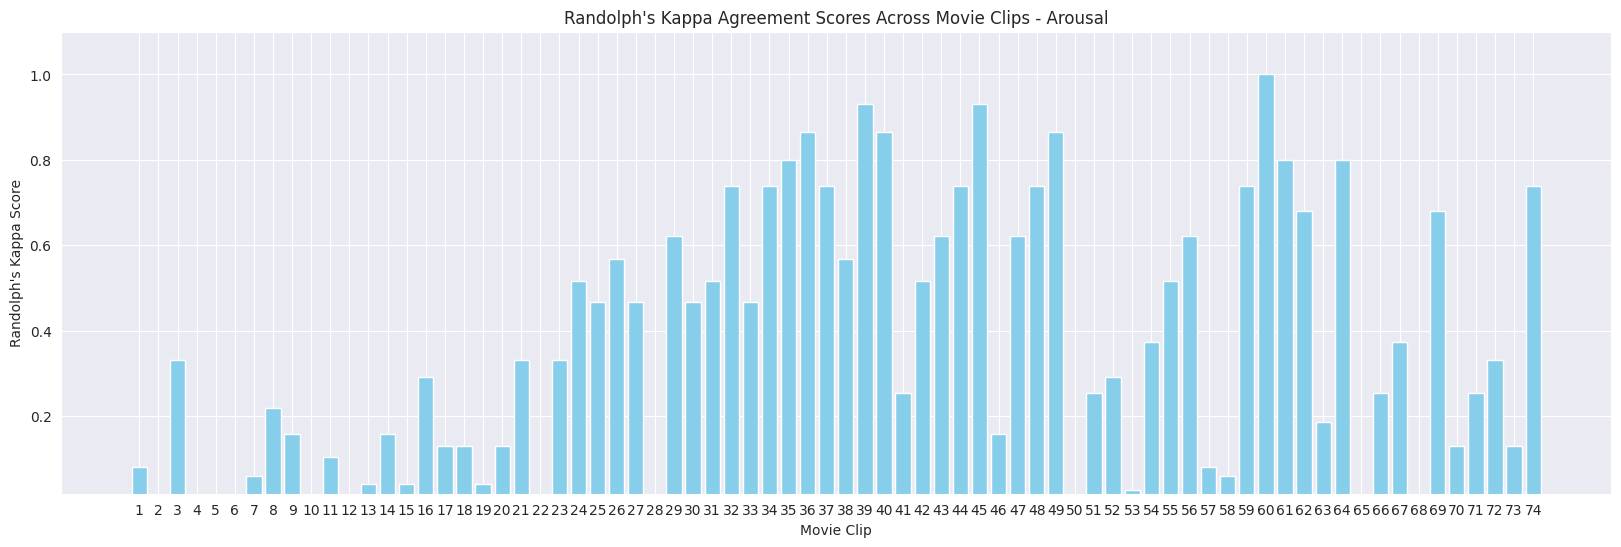

Randolph's Kappa Score: 0.37342424093785276


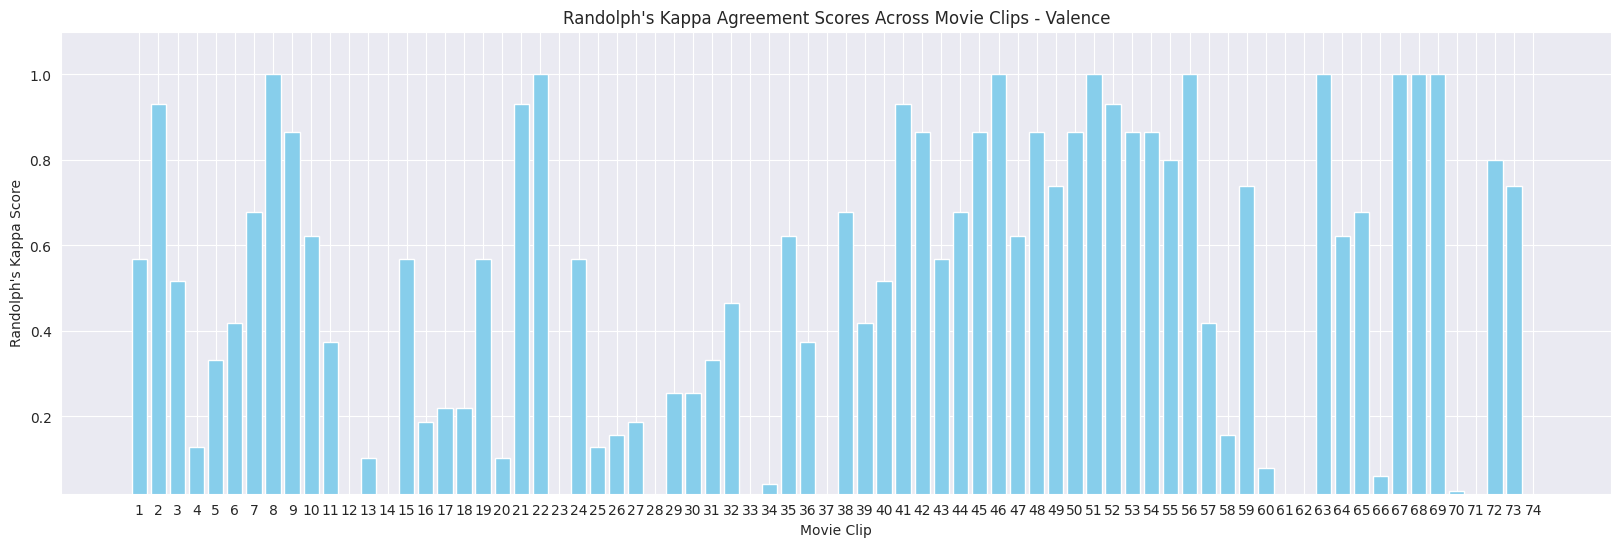

Randolph's Kappa Score: 0.5007602884190907


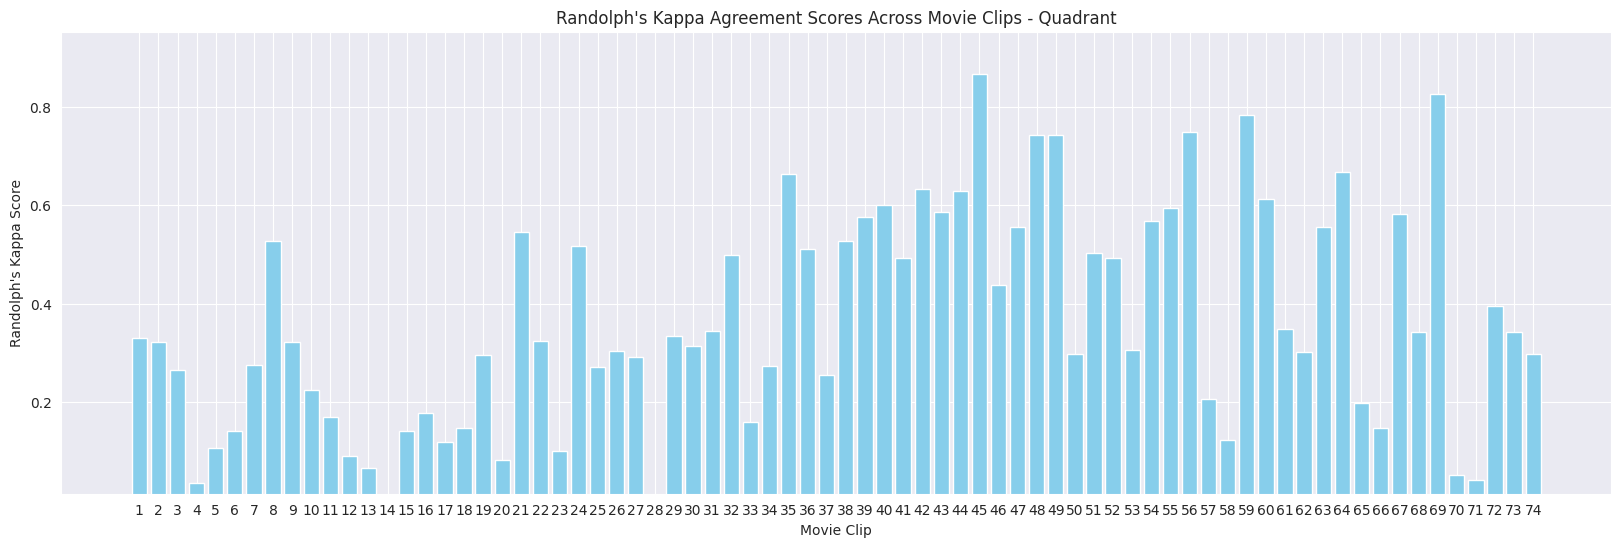

Randolph's Kappa Score: 0.3686063559021817


In [9]:
process_kappa( participant_responses_arousal, "Arousal")
process_kappa( participant_responses_valence, "Valence")
process_kappa(participant_responses_quadrant, "Quadrant")

Accuracy: 0.24
Per-Class Precision: [0.28611501 0.19665683 0.26337449 0.2004717 ]
Per-Class Recall: [0.45333333 0.26845638 0.08101266 0.12592593]
Macro Precision: 0.24
Macro Recall: 0.23
Weighted Precision: 0.24
Weighted Recall: 0.24

Classification Report:
              precision    recall  f1-score   support

           I       0.29      0.45      0.35       900
          II       0.20      0.27      0.23       745
         III       0.26      0.08      0.12       790
          IV       0.20      0.13      0.15       675

    accuracy                           0.24      3110
   macro avg       0.24      0.23      0.21      3110
weighted avg       0.24      0.24      0.22      3110

Accuracy: 0.50
Per-Class Precision: [0.43928036 0.52026197]
Per-Class Recall: [0.2        0.77264438]
Macro Precision: 0.48
Macro Recall: 0.49
Weighted Precision: 0.48
Weighted Recall: 0.50

Classification Report:
              precision    recall  f1-score   support

         Low       0.44      0.20     

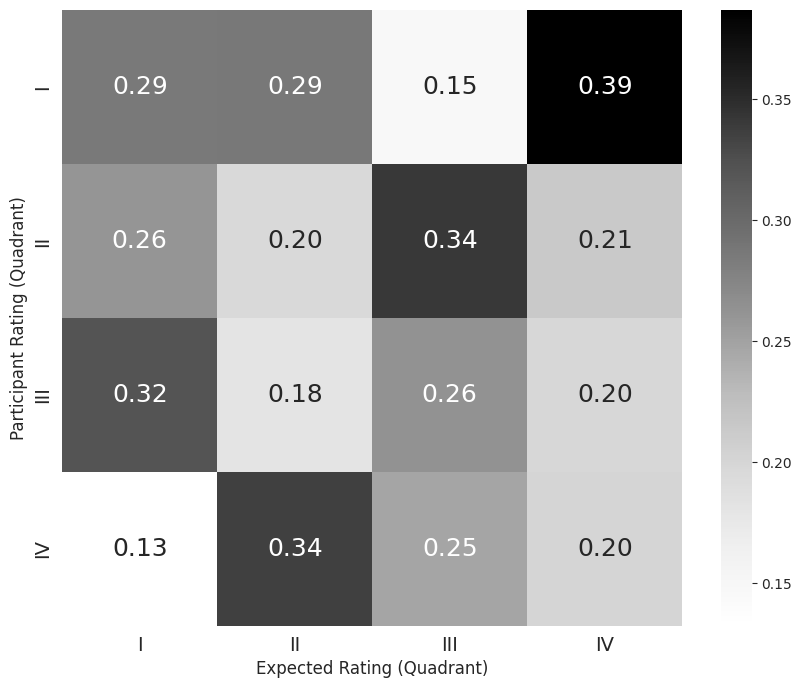

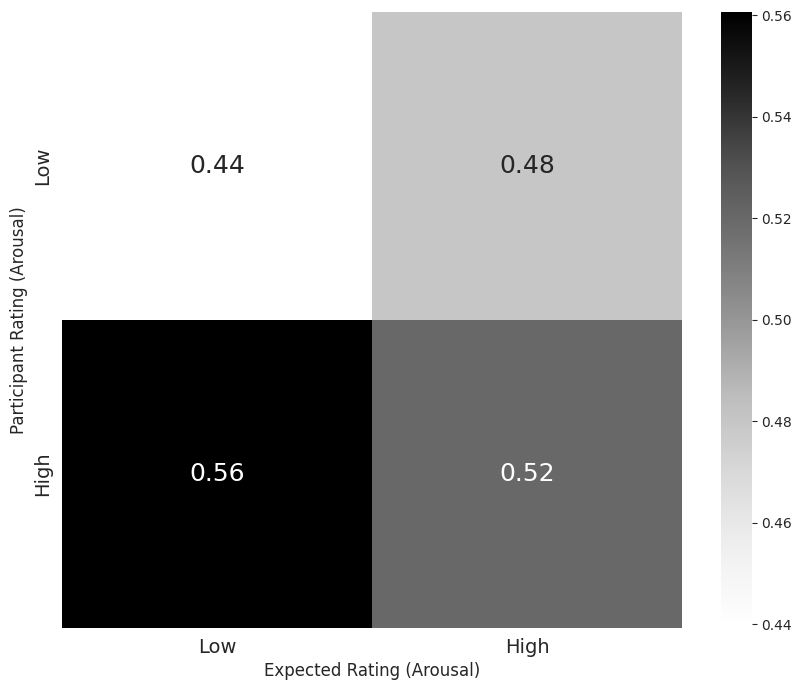

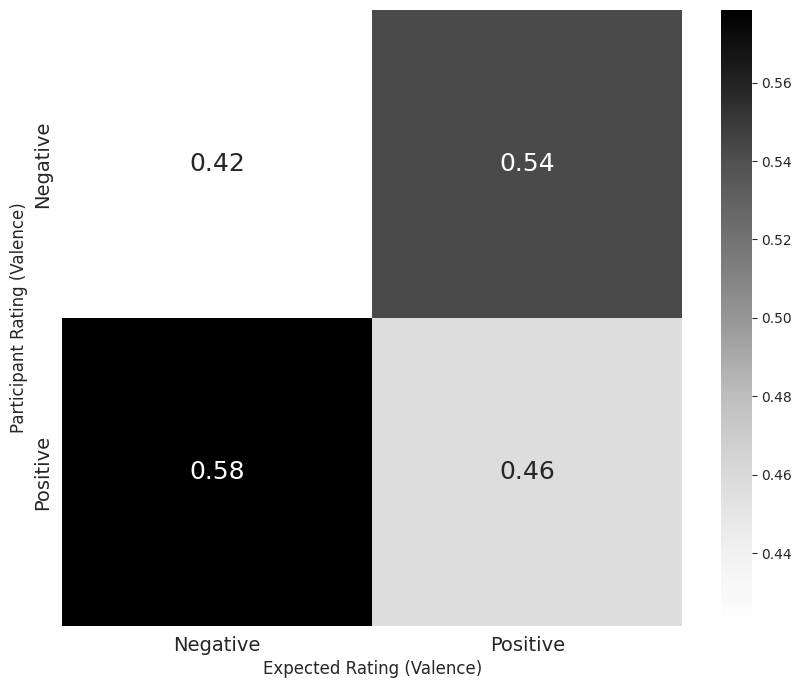

In [10]:

def stats(y_true, y_pred, classes):
    # Compute Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Compute Precision and Recall for Each Class
    precision = precision_score(y_true, y_pred, average=None)  # Per-class precision
    recall = recall_score(y_true, y_pred, average=None)        # Per-class recall

    # Macro and Weighted Averages
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')

    weighted_precision = precision_score(y_true, y_pred, average='weighted')
    weighted_recall = recall_score(y_true, y_pred, average='weighted')

    # Print Results
    print(f"Accuracy: {accuracy:.2f}")
    print("Per-Class Precision:", precision)
    print("Per-Class Recall:", recall)
    print(f"Macro Precision: {macro_precision:.2f}")
    print(f"Macro Recall: {macro_recall:.2f}")
    print(f"Weighted Precision: {weighted_precision:.2f}")
    print(f"Weighted Recall: {weighted_recall:.2f}")

    # Optional: Full Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))


def make_matrix(cm_responses, cm_labels, cm_classes, cm_xlabel, cm_ylabel, fname):
    non_neutral_movie_indices = [i for i, label in enumerate(cm_labels) if label != 0]
    confusion_responses = cm_responses[:, non_neutral_movie_indices]

    expected_labels = cm_labels[non_neutral_movie_indices]

    valid_responses = confusion_responses.flatten() != 0
    y_true = np.tile(expected_labels, confusion_responses.shape[0])[valid_responses]
    y_pred = confusion_responses.flatten()[valid_responses]
    stats(y_true, y_pred, cm_classes)
    # Generate confusion matrix
    cm = confusion_matrix(
        y_true,
        y_pred,
        normalize="pred"
    )

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap="Greys", xticklabels=cm_classes, yticklabels=cm_classes, annot_kws={"size": 18})
    plt.xlabel(cm_xlabel, fontsize=12)
    plt.ylabel(cm_ylabel, fontsize=12)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(fname, dpi=300, bbox_inches="tight")

cm_responses = participant_responses_quadrant
cm_labels = expected_responses_quadrant
cm_classes = ["I", "II", "III", "IV" ]
cm_xlabel = "Expected Rating (Quadrant)"
cm_ylabel = "Participant Rating (Quadrant)"
make_matrix(
    cm_responses,
    cm_labels,
    cm_classes,
    cm_xlabel,
    cm_ylabel,
    f"{dataset_output}/quadrant_matrix.png"
)

cm_responses = participant_responses_arousal
cm_labels = expected_responses_arousal
cm_classes = ["Low", "High" ]
cm_xlabel = "Expected Rating (Arousal)"
cm_ylabel = "Participant Rating (Arousal)"
make_matrix(
    cm_responses,
    cm_labels,
    cm_classes,
    cm_xlabel,
    cm_ylabel,
    f"{dataset_output}/arousal_matrix.png"
)

cm_responses = participant_responses_valence
cm_labels = expected_responses_valence
cm_classes = ["Negative", "Positive" ]
cm_xlabel = "Expected Rating (Valence)"
cm_ylabel = "Participant Rating (Valence)"
make_matrix(
    cm_responses,
    cm_labels,
    cm_classes,
    cm_xlabel,
    cm_ylabel,
    f"{dataset_output}/valence_matrix.png"
)
